# Modal Sense Classification

This project aims to re-implement the work and of Marsovic & Frank (2016).
The task is a modal sense classification of sentences containing the German modal verbs 'können', 'müssen', 'dürfen' and 'sollen'. The data for this task is taken from the EPOS Dataset, consisting of sentences from movie subtitles. The Marasovic et al. (2016) created the corpus to enlarge their existing dataset and be able to carry out more controlled experiments. The corpus was created via cross-lingual sense projection and a balanced version made available. 

The second dataset under investigation is a modality annotated version of the NZZ corpus (Müller et al. 2012, Roch 2018), from now on called NZZ Modality. The respective data was gathered from Swiss newspaper articles with an emphasis on samples containing specific preposotional phrase structures.

Both datasets will be used to explore the gerneralization capability of CNNs on the task of MSC, more specifically their ability to deal with varibility between the datasets at hand.
Results will be discussed in more detail in accompanying paper.


The Notebook is structured as follows:

Since the EPOS dataset will act as validation set in an attempt to replicate previous works, it will used for classification first. Then the model will be applied to the second dataset (NZZ Modality) and modified if needed.


1. EPOS Dataset Summary & Preparation
2. Definition Model Architecture
3. EPOS Dataset Training & Evaluation
4. Visualization

5. NZZ Modality Data Summary & Preparation
6. Split into multiple Training Sets
7. Adaptation Model Architecture
8. Classification & Comparison of Subsets






## Libraries

In [0]:
## Load all necessary libraries and tools
# Base Libraries

import pandas as pd
import numpy as np
from numpy import array
import io, os, sys
import string
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [0]:
# Machine Learning Libraries

%tensorflow_version 2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers, regularizers

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
# Flair Word Embeddings

!pip install flair
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

## EPOS Dataset

The data will be loaded via files.upload() for usage in google colab.

The data will then be split into the individual sentences (x) and their respective labels (y) for classification. The EPOS data is already separated into test and train set, still another split is made to create a development set.

After loading, the data will run through a preprocessing pipeline, where all sentences will be cleaned, meaning punctuation and other symbols will be removed. Then the sentences will be transformed into pre-trained word embeddings and zero-padded as to ensure that all sequences have the same length.

The labels will be encoded into categorical one-hot encodings.


### Load Data

In [0]:
# Upload Local Files into Temporary Google Colab Directory
data_train = files.upload() 
data_test = files.upload()

Saving duerfen.txt to duerfen (2).txt
Saving koennen.txt to koennen (2).txt
Saving muessen.txt to muessen (2).txt
Saving sollen.txt to sollen (2).txt


Saving duerfen.txt to duerfen (3).txt
Saving koennen.txt to koennen (3).txt
Saving muessen.txt to muessen (3).txt
Saving sollen.txt to sollen (3).txt


In [0]:
# Split Function

def split_xy(txt_file):
  x = []
  y = []
  text = open(txt_file, 'r')
  lines = text.readlines()
  text.close()
  for line in lines:
    split = line.split('\t')
    x.append(split[0])
    y.append(split[1][:-1])
  return x, y

In [0]:
# Split Train Set into Texts and Labels

x_sollen_raw, y_sollen_raw = split_xy('sollen.txt')
x_koennen_raw, y_koennen_raw = split_xy('koennen.txt')
x_muessen_raw, y_muessen_raw = split_xy('muessen.txt')
x_duerfen_raw, y_duerfen_raw = split_xy('duerfen.txt')

In [0]:
# Split Test Set into Texts and Labels

x_sollen_test, y_sollen_test = split_xy('sollen (1).txt')
x_koennen_test, y_koennen_test = split_xy('koennen (1).txt')
x_muessen_test, y_muessen_test = split_xy('muessen (1).txt')
x_duerfen_test, y_duerfen_test = split_xy('duerfen (1).txt')

### Summary

In [0]:
# Distribution of Classes among Samples in Train Set

dist = pd.DataFrame(data = {'Verb': ['duerfen', 'muessen', 'koennen', 'sollen'], 
        'Deontic': [y_duerfen_raw.count('de'), y_muessen_raw.count('de'), y_koennen_raw.count('de'), y_sollen_raw.count('de')], 
        'Epistemic': [y_duerfen_raw.count('ep'), y_muessen_raw.count('ep'), y_koennen_raw.count('ep'), y_sollen_raw.count('ep')], 
        'Dynamic': [y_duerfen_raw.count('dy'), y_muessen_raw.count('dy'), y_koennen_raw.count('dy'), y_sollen_raw.count('dy')],
        '# Samples': [len(y_duerfen_raw), len(y_muessen_raw), len(y_koennen_raw), len(y_sollen_raw)]})

dist.set_index('Verb')

dist

,Verb,Deontic,Epistemic,Dynamic,# Samples
0,duerfen,1000,1000,0,2000
1,muessen,1000,1000,0,2000
2,koennen,1000,1000,1000,3000
3,sollen,1000,1000,0,2000


In [0]:
# Cut out Dynamic Samples for Binary Classification
y_koennen_raw = y_koennen_raw[:1000]+ y_koennen_raw[2000:]
x_koennen_raw = x_koennen_raw[:1000]+ x_koennen_raw[2000:]

In [0]:
# Distribution of Classes among Samples in Test Set

dist_test = pd.DataFrame(data = {'Verb': ['duerfen', 'muessen', 'koennen', 'sollen'], 
        'Deontic': [y_duerfen_test.count('de'), y_muessen_test.count('de'), y_koennen_test.count('de'), y_sollen_test.count('de')], 
        'Epistemic': [y_duerfen_test.count('ep'), y_muessen_test.count('ep'), y_koennen_test.count('ep'), y_sollen_test.count('ep')], 
        'Dynamic': [y_duerfen_test.count('dy'), y_muessen_test.count('dy'), y_koennen_test.count('dy'), y_sollen_test.count('dy')],
        '# Samples': [len(y_duerfen_test), len(y_muessen_test), len(y_koennen_test), len(y_sollen_test)]})

dist_test.set_index('Verb')

dist_test

,Verb,Deontic,Epistemic,Dynamic,# Samples
0,duerfen,100,98,0,198
1,muessen,100,34,0,134
2,koennen,47,100,100,247
3,sollen,100,101,0,201


In [0]:
# Cut out Dynamic Samples for Binary Classification
y_koennen_test = y_koennen_test[:47] + y_koennen_test[147:]
x_koennen_test = x_koennen_test[:47] + x_koennen_test[147:]

In [0]:
# Comprehensive Data Frame (Train Set)

labels = y_duerfen_raw + y_muessen_raw + y_koennen_raw + y_sollen_raw
verbs = ['duerfen']*len(x_duerfen_raw) + ['muessen']*len(x_muessen_raw) + ['koennen']*len(x_koennen_raw) + ['sollen']*len(x_sollen_raw)
texts = x_duerfen_raw + x_muessen_raw + x_koennen_raw + x_sollen_raw

df = pd.DataFrame({'Sentence': texts,
                   'Modal Verb' : verbs,
                   'Label' : labels})

onehotdf = pd.get_dummies(df.Label)
pd.concat([df, onehotdf], axis=1)

,Sentence,Modal Verb,Label,de,ep
0,"Verzeihung , Gentlemen ... ... aber dieses Flu...",duerfen,de,1,0
1,lch darf kein Fett und kein Alkohol . Nur Wein .,duerfen,de,1,0
2,"Das bezweifle ich , denn damit dürfte illegale...",duerfen,de,1,0
3,Darf ich Ihnen im Namen des Hauses gratulieren ?,duerfen,de,1,0
4,Wir dürfen dann nicht ins Ausland und werden v...,duerfen,de,1,0
...,...,...,...,...,...
7995,Frau Präsidentin ! Ein Kollege sollte sich wun...,sollen,ep,0,1
7996,"Ja , sollte schon sein .",sollen,ep,0,1
7997,Das sollte einem hart vorkommen . Aber so ist ...,sollen,ep,0,1
7998,"- Ich fürchte , ich muss . So verlockend es au...",sollen,ep,0,1


<function matplotlib.pyplot.show>

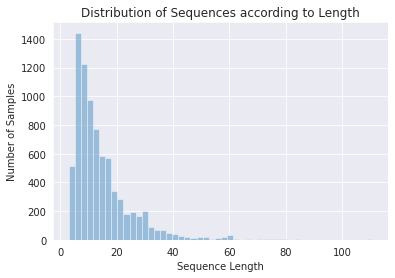

In [0]:
# Get Overview over Length of Texts (punctuation marks still included)

x = [len(s.split()) for s in texts]

sns.set_style('darkgrid')
sns.distplot(x, kde=False)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequences according to Length')
plt.show

In [0]:
# Max and Mean Sequence Length

max_len = max(x)
mean_len = np.mean(x)
print('max length: %d' %max_len)
print('mean length: %d' %mean_len)

max length: 111
mean length: 14


### Preprocessing


In [0]:
# Remove Punctuation Marks and Symbols from Texts

def clean_x(texts):
  cleanTexts = []
  for sent in texts:
    stripped = [w for w in sent.split() if w.isalpha()] #remove punctuation, integer and other symbols
    stripped = ' '.join(stripped)
    cleanTexts.append(stripped)
  return cleanTexts

In [0]:
# Encode Texts into Word Embeddings

def embed_x(cleanTexts):
  embeddings = WordEmbeddings('de-crawl') # load Flair embeddings
  embeddedSents = []
  for text in cleanTexts:
    sent = Sentence(text)
    embeddings.embed(sent) # transform each sentence into word vector sequence
    embeddedSents.append([t.embedding.numpy() for t in sent])
  return embeddedSents


In [0]:
# Padding

def pad_x(embeddedSents):
  padded = pad_sequences(embeddedSents, padding= 'post', dtype='float32', truncating = 'post', maxlen = 100) #200 pad embeddings to have same length
  return padded

# Note: Max Length for the EPOS Dataset is a Number of 95 Words per Sequence Punctuation and other Symbols excluded

In [0]:
# Encode Labels into Categorical One-Hot Vectors

def encode_y(labels):
  label_encoder = LabelEncoder()
  int_encoded = label_encoder.fit_transform(labels) # transform string labels into integers
  onehot_encoded = to_categorical(array(int_encoded)) # transform integers into n-dimensional one-hot encodings
  return onehot_encoded

In [0]:
# Process Train Set 

# Text Sequences
X_texts = texts
X_clean = clean_x(X_texts) # embed texts
X_emb = embed_x(X_clean)
X_train = pad_x(X_emb) # pad texts

# Labels
Y_train = labels
Y_train = encode_y(Y_train)

# Train Dev Split
x_train, x_dev, y_train, y_dev = train_test_split(X_train, Y_train, test_size = 0.2, random_state= 42)

# Individual Subsets
X_duerfen = X_train[:2000]
X_muessen = X_train[2000:4000]
X_koennen = X_train[4000:6000]
X_sollen = X_train[6000:]

Y_duerfen = Y_train[:2000]
Y_muessen = Y_train[2000:4000]
Y_koennen = Y_train[4000:6000]
Y_sollen = Y_train[6000:]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Check Dimensions via Shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (6400, 100, 300)
y_train shape: (6400, 2)


In [0]:
# Check Embeddings and One-Hot Label Encoding
print('X_train Sample Embedding:', X_train[0])
print('Y_train Sample Encoding:', Y_train[0])

X_train Sample Embedding: [[ 0.004  -0.0003 -0.0417 ...  0.028   0.0083  0.0174]
 [-0.032   0.0015 -0.0747 ...  0.0153  0.0053  0.0268]
 [ 0.0009  0.018   0.0223 ...  0.0483  0.0239 -0.0441]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
Y_train Sample Encoding: [1. 0.]


In [0]:
# Process Test Set

# Text Sequences
x_texts = x_duerfen_test + x_muessen_test + x_koennen_test + x_sollen_test
x_clean = clean_x(x_texts) #texts
x_emb = embed_x(x_clean)
x_test = pad_x(x_emb)

# Labels
y_test = y_duerfen_test + y_muessen_test + y_koennen_test + y_sollen_test
y_test = encode_y(y_test)

# Individual Subsets
x_duerfen = x_test[:198]
x_muessen = x_test[198:332]
x_koennen = x_test[332:479]
x_sollen = x_test[479:]

y_duerfen = y_test[:198]
y_muessen = y_test[198:332]
y_koennen = y_test[332:479]
y_sollen = y_test[479:]

# Note: Train Subsets are denoted by upper case character and Test Subsets by lower case character

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Check Dimensions via Shape
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_test shape: (680, 100, 300)
y_test shape: (680, 2)


## Classification

### Define Model

Following Kim (2014) original proposal, a one-layer 3-channel CNN Architecture was chosen. This marks a slight deviation from Marasovic & Frank (2016) who deployed a 1-channel architecture.

In [0]:
# Define One-Layer Mulit-Channel Architecture

def define_model(length, dims): #sequence length, vocab size/embedding dims
  # channel 1
  inputs1 = Input(shape=(length, dims))
  conv1 = Conv1D(filters = 128, kernel_size = 4, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs1)#(embedding1) #filter size 4
  drop1 = Dropout(0.5)(conv1) # higher drop out = slower and more consistent learning
  pool1 = MaxPooling1D(pool_size = 2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length, dims))
  conv2 = Conv1D(filters = 128, kernel_size = 6, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs2)#(embedding2) #filter size 6
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size = 2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length, dims))
  conv3 = Conv1D(filters = 128, kernel_size = 8, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs3) #(embedding3) #filter size 8
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size = 2)(drop3)
  flat3 = Flatten()(pool3)
  # merge layer
  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(10, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(merged) #reg!
  outputs = Dense(2, activation = 'softmax', activity_regularizer=regularizers.l2(0.001))(dense1) # regularizer slows down learning
  model = Model(inputs = [inputs1, inputs2, inputs3], outputs  = outputs)
  # compile
  model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy']) #0.0001 lower lr to counteract fast overfitting
  # summary 
  print(model.summary())

  return model

In [0]:
# Instantiate Model

model = define_model(100, 300) #95, 300

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 97, 128)      153728      input_4[0][0]                    
____________________________________________________________________________________________

### Training & Evaluation

In [0]:
# Training on Train and Dev Set

history = model.fit(x = [x_train, x_train, x_train], y = y_train, validation_data = ([x_dev, x_dev, x_dev], y_dev), shuffle = True, epochs = 20, batch_size = 16) #16

Epoch 1/20
400/400 [==============================] - 40s 101ms/step - loss: 0.4222 - accuracy: 0.8178 - val_loss: 0.3337 - val_accuracy: 0.8825
Epoch 2/20
400/400 [==============================] - 40s 100ms/step - loss: 0.2221 - accuracy: 0.9336 - val_loss: 0.2221 - val_accuracy: 0.9200
Epoch 3/20
400/400 [==============================] - 40s 100ms/step - loss: 0.1648 - accuracy: 0.9508 - val_loss: 0.2059 - val_accuracy: 0.9362
Epoch 4/20
400/400 [==============================] - 40s 100ms/step - loss: 0.1249 - accuracy: 0.9652 - val_loss: 0.1743 - val_accuracy: 0.9456
Epoch 5/20
400/400 [==============================] - 40s 100ms/step - loss: 0.0914 - accuracy: 0.9784 - val_loss: 0.1859 - val_accuracy: 0.9381
Epoch 6/20
400/400 [==============================] - 40s 100ms/step - loss: 0.0885 - accuracy: 0.9791 - val_loss: 0.2035 - val_accuracy: 0.9413
Epoch 7/20
400/400 [==============================] - 40s 100ms/step - loss: 0.0799 - accuracy: 0.9805 - val_loss: 0.1709 - val_ac

In [0]:
# Evaluation on Test Set

loss_all, metric_all = model.evaluate(x= [x_test, x_test, x_test], y = y_test, batch_size = 16, verbose = 1)
print('Accuracy over whole Test Set: %.2f \n' % metric_all)

43/43 [==============================] - 1s 31ms/step - loss: 0.1949 - accuracy: 0.9500
Accuracy over whole Test Set: 0.95 



In [0]:
# Evaluation on Test Subsets

loss_k, metrics_k = model.evaluate(x= [x_koennen, x_koennen, x_koennen], y = y_koennen, batch_size = 16, verbose = 1)
loss_s, metrics_s = model.evaluate(x= [x_sollen, x_sollen, x_sollen], y = y_sollen, batch_size = 16, verbose = 1)
loss_m, metrics_m = model.evaluate(x= [x_muessen, x_muessen, x_muessen], y = y_muessen, batch_size = 16, verbose = 1)
loss_d, metrics_d = model.evaluate(x= [x_duerfen, x_duerfen, x_duerfen], y = y_duerfen, batch_size = 16, verbose = 1)

print('Accuracy Subset "koennen": %.2f \n' % metrics_k,
      'Accuracy Subset "sollen": %.2f \n' % metrics_s,
      'Accuracy Subset "muessen": %.2f \n' % metrics_m,
      'Accuracy Subset "duerfen": %.2f' % metrics_d)

13/13 [==============================] - 0s 28ms/step - loss: 0.0537 - accuracy: 0.9949
Accuracy Subset "koennen": 0.97 
 Accuracy Subset "sollen": 0.92 
 Accuracy Subset "muessen": 0.91 
 Accuracy Subset "duerfen": 0.99 



In [0]:
# Save Model for Later Use
model.save('ModalSenseBinaryCNN100Neu.h5')

### Visualization

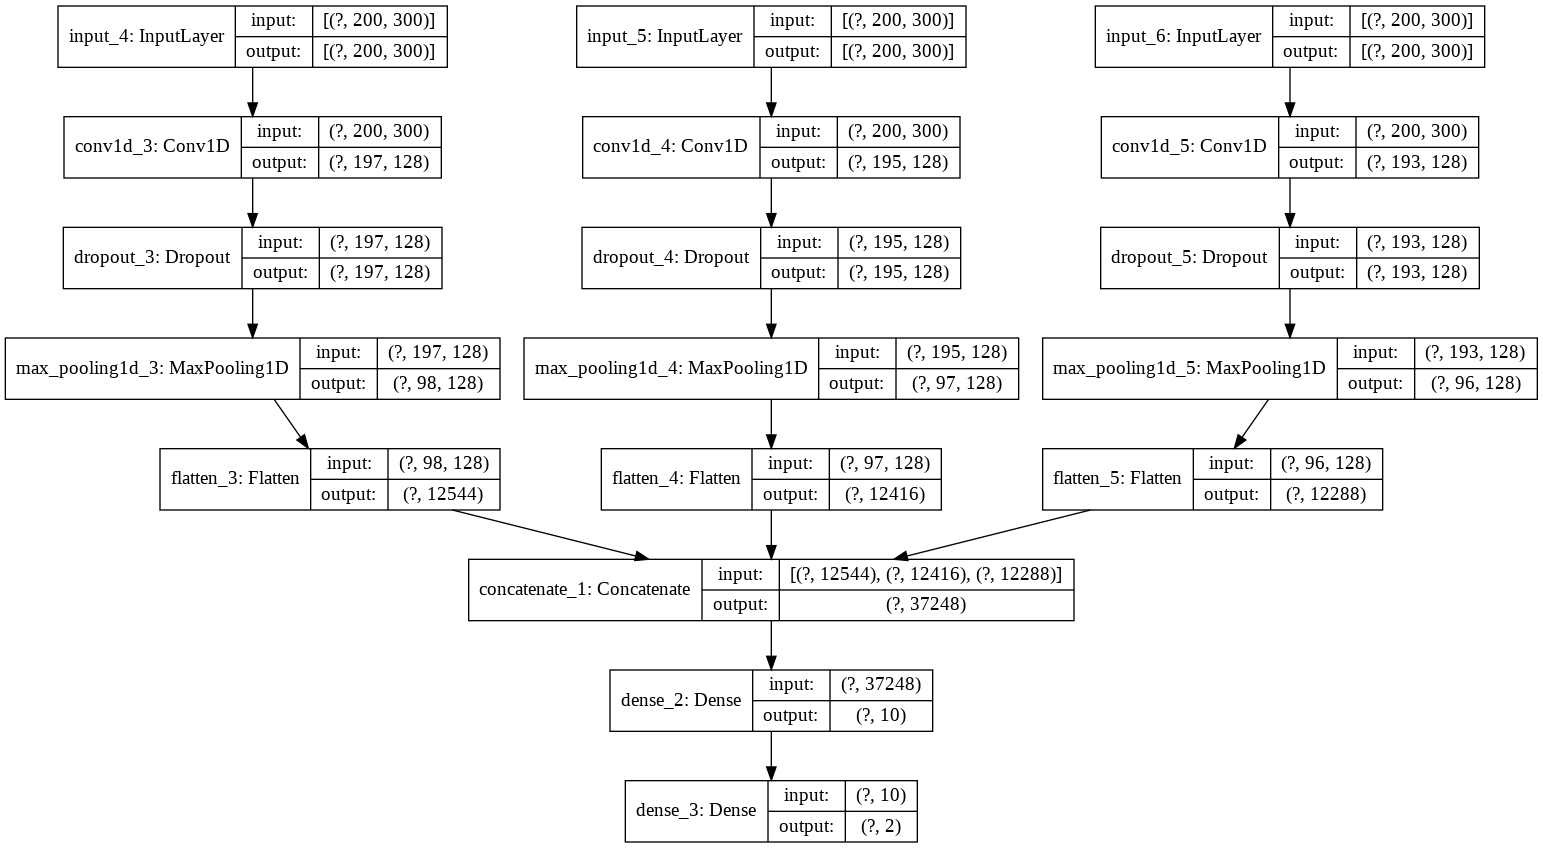

In [0]:
# Model Architecture

plot_model(model, show_shapes = True)#, to_file='MultiChannelModalSenseClf.png')

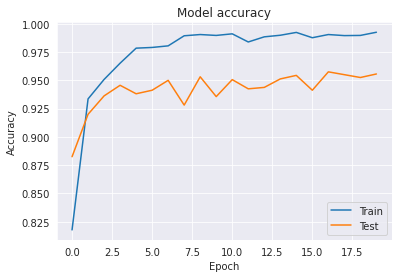

In [0]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Classes'], loc='lower right')
plt.savefig('ModalSenseBinaryAccuracy100Neu.png')
plt.show()


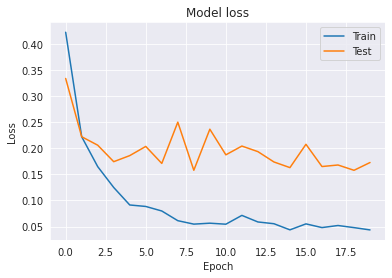

In [0]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('ModalBinaryClassLoss100Neu.png')
plt.show()

## NZZ Modality Dataset

The NZZ Modality Dataset is preprocessed basically the same as the EPOS Datasets.

The pre-trained EPOS Model was evaluated on the NZZ Modality corpus. Due to unsatisfactory results, the model architecture was refined and trained on the NZZ Modality data to achieve better performance.

Further, number of Subsets were created to investigate the performance of the CNN Model. Sets were created with respect to the location of the modal verb, Target Sentence vs Matrix Sentence and broadness of category (root - epistemic vs deontic - epistemic).

### Load Data

In [0]:
data = files.upload() #upload local files into temporary google colab directory

Saving NZZ_BEI_MIT_OHNE_Modalverben_lex.xlsx to NZZ_BEI_MIT_OHNE_Modalverben_lex.xlsx


In [0]:
# Create Dataframe

df = pd.read_excel('NZZ_BEI_MIT_OHNE_Modalverben_lex.xlsx') # whole data
df_modals_onlyTS = df[df['TS.Modalverb'] == 'ts_mv'] # data target sentences containing modal verbs only
df_modals_onlyTS

,Präposition,global_id,kontext,Prep.Meaning,Syn.Dep,TS.V.Temp,TS.V.Modus,TS.V.Diath,TS.V.Aktionsart,TS.Negation,TS.Modalverb,TS.Modalverb.Lex,TS.Mod.Les.sp,TS.Mod.Les.gr,TS.Verbsem,TS.Satzadv,TS.Nomsem,TS.Adjsem,TS.Konstruktion,TS.Modalpartikeln,TS.Fokuspartikeln,TS.Konjadv,TS.Faktivitaet,TS.Gener.Episod,TS.Satzmodus,TS.Source,MS.vorhanden,MS.V.Temp,MS.V.Modus,MS.Negation,MS.Modalverb,MS.Modalverb.Lex,MS.Mod.Les.sp,MS.Mod.Les.gr,MS.Verbsem,MS.Satzadv,MS.Nomsem,MS.Adjsem,MS.Konstruktion,MS.Modalpartikeln,MS.Fokpuspartikeln,MS.Konjadv,MS.Faktivitaet,MS.Gener.Episod,MS.Satzmodus,MS.Source
0,bei,nzz_1994_11_23_a98_seg7_s9_hit1,Möglich sei eine Akzentverschiebung auf Betrie...,konditional,Syn(V),ts_temp(Praes),ts_modus(KonII),ts_diath(aktiv),ts_v_akt(state),ts_dopneg,ts_mv,ts_mv_lex(koennen),ts_mv_rh(circum),ts_mv_rhg(root),ts_vs_kfak,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_fokpart(KDS:auch/nur/selbst);fokpart,ts_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_smood(deklarativ),ts_no_source,ms_no,ms_no_temp,ms_no_modus,ms_no_neg,ms_no_mv,ms_no_mv_lex,ms_no_mv_rh,ms_no_mv_rhg,ms_no_vs,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_no_konjadv,ms_no_fakstat,ms_no_epigenstat,ms_no_smood,ms_no_source
1,bei,nzz_1996_05_17_a143_seg3_s5_hit1,Diese Vorspiegelung falscher Vorstellungen mac...,bezugspunkt,Syn(V),ts_temp(Praes),ts_modus(Ind),ts_diath(aktiv),ts_v_akt(state),ts_neg–,ts_mv,ts_mv_lex(wollen;muessen),ts_mv_rh(bul;circum),ts_mv_rhg(root;root),ts_no_vs,ts_no_modsadv,ts_no_mod_nom,ts_adj_nonfak,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener.nom),ts_smood(deklarativ),ts_no_source,ms_no,ms_no_temp,ms_no_modus,ms_no_neg,ms_no_mv,ms_no_mv_lex,ms_no_mv_rh,ms_no_mv_rhg,ms_no_vs,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_no_konjadv,ms_no_fakstat,ms_no_epigenstat,ms_no_smood,ms_no_source
2,bei,nzz_1996_07_17_a51_seg2_s5_hit1,** Bei dem Anschlag ** im Juli 1994 hätten meh...,zuordnung,Syn(V),ts_temp(Praet),ts_modus(KonII),ts_diath(passiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(sollen),ts_mv_rh(teleo),ts_mv_rhg(root),ts_no_vs,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(kfak),ts_epigenstat(spez),ts_smood(deklarativ),ts_no_source,ms_no,ms_no_temp,ms_no_modus,ms_no_neg,ms_no_mv,ms_no_mv_lex,ms_no_mv_rh,ms_no_mv_rhg,ms_no_vs,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_no_konjadv,ms_no_fakstat,ms_no_epigenstat,ms_no_smood,ms_no_source
3,bei,nzz_1999_02_26_a41_seg3_s12_hit1,Deshalb sollen die logistischen und administra...,zuordnung,Syn(N),ts_temp(Praes),ts_modus(Ind),ts_diath(passiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(sollen),ts_mv_rh(teleo),ts_mv_rhg(root),ts_no_vs,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_smood(deklarativ),ts_no_source,ms_no,ms_no_temp,ms_no_modus,ms_no_neg,ms_no_mv,ms_no_mv_lex,ms_no_mv_rh,ms_no_mv_rhg,ms_no_vs,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_no_konjadv,ms_no_fakstat,ms_no_epigenstat,ms_no_smood,ms_no_source
4,bei,nzz_1996_11_27_a132_seg44_s6_hit1,** Bei einem Album ** von Public Enemy müsse e...,zuordnung,Syn(V),ts_temp(Praes),ts_modus(KonI),ts_diath(aktiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(muessen),ts_mv_rh(circum),ts_mv_rhg(root),ts_no_vs,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_fokpart(KDS:auch/nur/selbst),ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(spez),ts_smood(deklarativ),ts_no_source,ms_no,ms_no_temp,ms_no_modus,ms_no_neg,ms_no_mv,ms_no_mv_lex,ms_no_mv_rh,ms_no_mv_rhg,ms_no_vs,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_no_konjadv,ms_no_fakstat,ms_no_epigenstat,ms_no_smood,ms_no

In [0]:
# DF Modal Verb found in Matrix Sentence

df_modals_onlyMS = df[df['MS.Modalverb'] == 'ms_mv'] 
#df_modals_onlyMS

,Präposition,global_id,kontext,Prep.Meaning,Syn.Dep,TS.V.Temp,TS.V.Modus,TS.V.Diath,TS.V.Aktionsart,TS.Negation,TS.Modalverb,TS.Modalverb.Lex,TS.Mod.Les.sp,TS.Mod.Les.gr,TS.Verbsem,TS.Satzadv,TS.Nomsem,TS.Adjsem,TS.Konstruktion,TS.Modalpartikeln,TS.Fokuspartikeln,TS.Konjadv,TS.Faktivitaet,TS.Gener.Episod,TS.Satzmodus,TS.Source,MS.vorhanden,MS.V.Temp,MS.V.Modus,MS.Negation,MS.Modalverb,MS.Modalverb.Lex,MS.Mod.Les.sp,MS.Mod.Les.gr,MS.Verbsem,MS.Satzadv,MS.Nomsem,MS.Adjsem,MS.Konstruktion,MS.Modalpartikeln,MS.Fokpuspartikeln,MS.Konjadv,MS.Faktivitaet,MS.Gener.Episod,MS.Satzmodus,MS.Source
5,bei,nzz_1996_10_01_a100_seg11_s3_hit1,"Damit wird aber übersehen , dass diese Obligat...",konditional,Syn(V),ts_temp(Praes),ts_modus(Ind),ts_diath(passiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(koennen),ts_mv_rh(circum),ts_mv_rhg(root),ts_no_vs,ts_no_modsadv,ts_nom_nonfak,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_no_smood,ts_no_source,ms_yes,ms_temp(Praes),ms_modus(Ind),ms_neg–,ms_mv,ms_mv_lex(muessen),ms_mv_rh(deon),ms_mv_rhg(root),ms_vs_kfak,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_konjadv,ms_fakstat(nonfak),ms_epigenstat(gener),ms_smood(deklarativ),ms_no_source
82,bei,nzz_1999_06_11_a34_seg1_s22_hit1,Schliesslich stellen sich aber auch bei der Re...,regiert,Syn(V),ts_temp(Praes),ts_modus(Ind),ts_diath(aktiv),ts_v_akt(state),ts_neg–,ts_mv,ts_mv_lex(wollen),ts_mv_rh(bul),ts_mv_rhg(root),ts_vs_fak,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_no_smood,ts_no_source,ms_yes,ms_temp(Praes),ms_modus(Ind),ms_no_neg,ms_mv,ms_mv_lex(muessen),ms_mv_rh(teleo),ms_mv_rhg(root),ms_no_vs,ms_no_modsadv,ms_nom_fak,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_fokpart,ms_konjadv,ms_fakstat(fak;nonfak),ms_epigenstat(gener),ms_smood(deklarativ),ms_no_source
86,bei,nzz_1999_06_08_a88_seg8_s7_hit1,"Dieses habe den Vorteil , dass frühere Verfehl...",zuordnung,Syn(Kon),ts_temp(Praes),ts_modus(KonI),ts_diath(aktiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(koennen),ts_mv_rh(circum),ts_mv_rhg(root),ts_vs_fak,ts_no_modsadv,ts_nom_nonfak,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_konjadv,ts_fakstat(nonfak),ts_epigenstat(spez),ts_no_smood,ts_no_source,ms_yes,ms_temp(Praes;Praes),ms_modus(KonI;KonII),ms_no_neg,ms_mv,ms_mv_lex(muessen),ms_mv_rh(epist),ms_mv_rhg(epist),ms_no_vs,ms_no_modsadv,ms_nom_fak,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_konjadv,ms_fakstat(nonfak),ms_epigenstat(spez),ms_smood(deklarativ),ms_no_source
91,bei,nzz_1997_08_14_a31_seg2_s4_hit1,"Blocher erklärte dem Journalisten , dass man G...",bezugspunkt,Syn(V),ts_temp(Praes),ts_modus(KonI),ts_diath(aktiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(muessen),ts_mv_rh(deon),ts_mv_rhg(root),ts_vs_fak,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_no_smood,ts_no_source,ms_yes,ms_temp(Praet),ms_modus(Ind),ms_dopneg,ms_mv,ms_mv_lex(koennen),ms_mv_rh(circum),ms_mv_rhg(root),ms_vs_nonfak,ms_no_modsadv,ms_no_mod_nom,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_fokpart,ms_no_konjadv,ms_fakstat(nonfak),ms_epigenstat(spez),ms_smood(deklarativ),ms_source
131,bei,nzz_1997_05_21_a147_seg11_s6_hit1,- Man mag über das Ausmass eines sinnvollen Da...,konditional,Syn(N),ts_temp(Praes),ts_modus(Ind),ts_diath(aktiv),ts_v_akt(state),ts_no_neg,ts_mv,ts_mv_lex(sollen),ts_mv_rh(evid),ts_mv_rhg(epist),ts_no_vs,ts_no_modsadv,ts_no_mod_nom,ts_no_mod_adj,ts_no_mod_konstr,ts_no_modpart,ts_no_fokpart,ts_no_konjadv,ts_fakstat(nonfak),ts_epigenstat(gener),ts_no_smood,ts_no_source,ms_yes,ms_temp(Praes),ms_modus(Ind),ms_neg–,ms_mv,ms_mv_lex(moegen),ms_mv_rh(circum),ms_mv_rhg(root),ms_vs_fak,ms_no_modsadv,ms_nom_fak,ms_no_mod_adj,ms_no_mod_konstr,ms_no_modpart,ms_no_fokpart,ms_konjad

### Summary

##### Target Sentences

In [0]:
# Distribution of Modal Verbs TS

modal_verbsTS = list(df_modals_onlyTS['TS.Modalverb.Lex'])
mv_distTS = {i : modal_verbsTS.count(i) for i in set(modal_verbsTS)}
verbs = [key for key,val in mv_distTS.items()]
samples = [val for key,val in mv_distTS.items()]
df_dist_mvTS = pd.DataFrame({'Modal Verb': verbs, 
                              'Samples' : samples})

df_dist_mvTS.sort_values(by = ['Samples'], ascending = False)

,Modal Verb,Samples
4,ts_mv_lex(koennen),430
17,ts_mv_lex(sollen),161
10,ts_mv_lex(muessen),146
0,ts_mv_lex(duerfen),132
1,ts_mv_lex(wollen),83
13,ts_mv_lex(moegen),19
7,ts_mv_lex(scheinen),15
8,ts_mv_lex(drohen),8
12,ts_mv_lex(versprechen),5
6,ts_mv_lex(brauchen),4


In [0]:
# Distribution of Data among Modal Sense Categories (broad) TS

modal_label_grTS = list(df_modals_onlyTS['TS.Mod.Les.gr'])
label_dist_grTS = {i : modal_label_grTS.count(i) for i in set(modal_label_grTS)}
labels = [key for key,val in label_dist_grTS.items()]
samples = [val for key,val in label_dist_grTS.items()]
df_dist_cat_broadTS = pd.DataFrame({'Labels': labels, 
                              'Samples' : samples})

df_dist_cat_broadTS

,Labels,Samples
0,ts_mv_rhg(epist;root),4
1,ts_mv_rhg(root;root),3
2,ts_mv_rhg(ambig),89
3,ts_mv_rhg(epist),169
4,ts_mv_rhg(narr),2
5,ts_mv_rhg(root),748


In [0]:
# Distribution of Data among Modal Sense Categories (narrow)

modal_label_spTS = list(df_modals_onlyTS['TS.Mod.Les.sp'])
label_dist_spTS = {i : modal_label_spTS.count(i) for i in set(modal_label_spTS)}
labels = [key for key,val in label_dist_spTS.items()]
samples = [val for key,val in label_dist_spTS.items()]
df_dist_cat_narTS = pd.DataFrame({'Labels': labels, 
                              'Samples' : samples})

df_dist_cat_narTS

,Labels,Samples
0,ts_mv_rhg(deon),1
1,ts_mv_rh(bul;circum),1
2,ts_mv_rh(evid;deon),2
3,ts_mv_rh(deon),198
4,ts_mv_rh(evid;bul),2
5,ts_mv_rh(evid),49
6,ts_mv_rh(circum),345
7,ts_mv_rh(deon;bul),1
8,ts_mv_rh(teleo;deon),1
9,ts_mv_rh(teleo),102


In [0]:
# Filter DataFrame for Epistemic and Deontic only

label_list = ['ts_mv_rh(deon)', 'ts_mv_rh(epist)']
df_modal_epde = df_modals_onlyTS[df_modals_onlyTS['TS.Mod.Les.sp'].isin(label_list)]
#df_modal_epde

In [0]:
# Filter DataFrame for Epistemic and Root only

label_list = [key for key, value in label_dist_grTS.items() if value > 100]
df_modal_binaryTS = df_modals_onlyTS[df_modals_onlyTS['TS.Mod.Les.gr'].isin(label_list)]
#df_modal_binaryTS


In [0]:
# Get Texts and Labels

# Root & Epistemic (broad categories)
texts_binaryTS = list(df_modal_binaryTS['kontext'])
labels_binaryTS = [label[10:-1] for label in list(df_modal_binaryTS['TS.Mod.Les.gr'])]

# Deontic & Epistemic (narrow categories)
texts_epde = list(df_modal_epde['kontext'])
labels_epde = [label[10:-1] for label in list(df_modal_epde['TS.Mod.Les.sp'])]

<function matplotlib.pyplot.show>

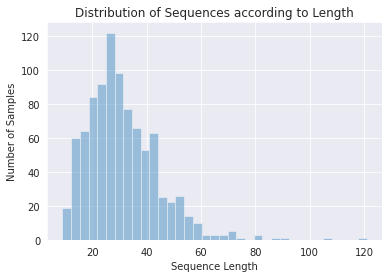

In [0]:
# Get Overview over Length of Texts (still includes punctuation marks)

x = [len(s.split()) for s in texts_binaryTS]

sns.set_style('darkgrid')
sns.distplot(x, kde=False)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequences according to Length')
plt.show

In [0]:
# Max and Mean Sequence Length

max_len = max(x)
mean_len = np.mean(x)
print('max length: %d' %max_len)
print('mean length: %d' %mean_len)

max length: 121
mean length: 30


#### Matrix Sentences

In [0]:
# Distribution of Modal Verbs MS

modal_verbsMS = list(df_modals_onlyMS['MS.Modalverb.Lex'])
mv_distMS = {i : modal_verbsMS.count(i) for i in set(modal_verbsMS)}
verbsMS = [key for key,val in mv_distMS.items()]
samplesMS = [val for key,val in mv_distMS.items()]
df_dist_mvMS = pd.DataFrame({'Modal Verb': verbsMS, 
                              'Samples' : samplesMS})

df_dist_mvMS.sort_values(by = ['Samples'], ascending = False)

,Modal Verb,Samples
7,ms_mv_lex(koennen),89
15,ms_mv_lex(muessen),52
3,ms_mv_lex(sollen),36
2,ms_mv_lex(wollen),35
19,ms_mv_lex(duerfen),20
13,ms_mv_lex(moegen),13
12,ms_mv_lex(scheinen),13
9,ms_mv_lex(muessen;koennen),4
5,ms_mv_lex(brauchen),3
11,ms_mv_lex(koennen;muessen),2


In [0]:
# Distribution of Data among Modal Sense Categories (broad) MS

modal_label_grMS = list(df_modals_onlyMS['MS.Mod.Les.gr'])
label_dist_grMS = {i : modal_label_grMS.count(i) for i in set(modal_label_grMS)}
labelsMS = [key for key,val in label_dist_grMS.items()]
samplesMS = [val for key,val in label_dist_grMS.items()]
df_dist_cat_broadMS = pd.DataFrame({'Labels': labelsMS, 
                              'Samples' : samplesMS})

df_dist_cat_broadMS

,Labels,Samples
0,ms_mv_rhg(root;root),6
1,ms_mv_rhg(root;epist),5
2,ms_mv_rhg(epist),70
3,ms_mv_rhg(epist;root),4
4,ms_mv_rhg(root),193
5,ms_mv_rhg(ambig),3


In [0]:
# Distribution of Data among Modal Sense Categories (narrow) MS

modal_label_spMS = list(df_modals_onlyMS['MS.Mod.Les.sp'])
label_dist_spMS = {i : modal_label_spMS.count(i) for i in set(modal_label_spMS)}
labelsMS = [key for key,val in label_dist_spMS.items()]
samplesMS = [val for key,val in label_dist_spMS.items()]
df_dist_cat_narMS = pd.DataFrame({'Labels': labelsMS, 
                              'Samples' : samplesMS})

df_dist_cat_narMS

,Labels,Samples
0,ms_mv_rh(deon;circum),1
1,ms_mv_rh(ambig),5
2,ms_mv_rh(circum;circum),1
3,ms_mv_rh(epist),47
4,ms_mv_rh(circum;evid),2
5,ms_mv_rh(bul;circum),1
6,ms_mv_rh(teleo),27
7,ms_mv_rh(evid),22
8,ms_mv_rh(epist;bul),1
9,ms_mv_rh(circum;epist),1


In [0]:
# Filter DataFrame for Epistemic and Root only

label_list = [key for key, value in label_dist_grMS.items() if value > 50]
df_modal_binaryMS = df_modals_onlyMS[df_modals_onlyMS['MS.Mod.Les.gr'].isin(label_list)]

In [0]:
# Get Texts and Labels

texts_binaryMS = list(df_modal_binaryMS['kontext'])
labels_binaryMS = [label[10:-1] for label in list(df_modal_binaryMS['MS.Mod.Les.gr'])]

<function matplotlib.pyplot.show>

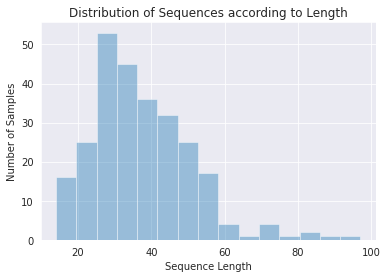

In [0]:
# Get Overview over Length of Texts (still includes punctuation marks)

x = [len(s.split()) for s in texts_binaryMS]

sns.set_style('darkgrid')
sns.distplot(x, kde=False)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequences according to Length')
plt.show

In [0]:
# Max and Mean Sequence Length

max_len = max(x)
mean_len = np.mean(x)
print('max length: %d' %max_len)
print('mean length: %d' %mean_len)

max length: 97
mean length: 37


### Preprocessing

In [0]:
def clean_and_embed_pd(texts):
  embeddings = WordEmbeddings('de-crawl') # load embeddings
  embeddedSents = []
  for sent in texts:
    tokens = sent.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
    stripped = ' '.join(tokens)
    embedded = Sentence(stripped)
    embeddings.embed(embedded) # transform each sentence into sequence consisting of word vectors
    embeddedSents.append([t.embedding.numpy() for t in embedded])
  return embeddedSents

In [0]:
# Preprocessing Target Sentence Subset (broad categories)

# Process Text Sequences 
x_cleanTS = clean_and_embed_pd(texts_binaryTS)
x_binaryTS = pad_x(x_cleanTS)

# Process Labels 
y_binaryTS = encode_y(labels_binaryTS)

# Train Test Split
x_trainTS, x_testTS, y_trainTS, y_testTS = train_test_split(x_binaryTS, y_binaryTS, test_size = 0.2, random_state = 42)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Preprocessing Matrix Sentence Subset (broad categories)

# Process Text Sequences
x_cleanMS = clean_and_embed_pd(texts_binaryMS)
x_binaryMS = pad_x(x_cleanMS)

# Process Labels
y_binaryMS = encode_y(labels_binaryMS)

# Train Test Split
x_trainMS, x_testMS, y_trainMS, y_testMS = train_test_split(x_binaryMS, y_binaryMS, test_size = 0.2, random_state = 42)

In [0]:
# Preprocessing Target Sentence Subset (narrow categories)

# Process Text Sequences
x_clean_epde = clean_and_embed_pd(texts_epde)
x_epde = pad_x(x_clean_epde)

# Process Labels
y_epde = encode_y(labels_epde)

# Train Test Split
x_train_epde, x_test_epde, y_train_epde, y_test_epde = train_test_split(x_epde, y_epde, test_size = 0.2, random_state = 42)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Check Shapes

print(y_binaryTS.shape)
print(x_binaryTS.shape)

(917, 2)
(917, 100, 300)


### Classification

#### Pre-trained Model

In [0]:
#loaded_model = load_model('ModalSenseBinaryCNN100Neu.h5') # load pre-trained model with weights, etc

In [0]:
#loaded_model.summary()

In [0]:
# Evaluation of pre-trained EPOS Model on NZZ Modality Dataset

#loss, metrics = loaded_model.evaluate( x= [x_binary, x_binary, x_binary], y = y_binary, batch_size = 16, verbose = 1)

17/17 [==============================] - 1s 30ms/step - loss: 3.4878 - accuracy: 0.4106


In [0]:
# Transfer Learning on pre-trained Model

#history_lm = loaded_model.fit(x = [x_trainr, x_trainr, x_trainr], y = y_trainr, validation_data = ([x_testr, x_testr, x_testr], y_testr), batch_size= 16, shuffle = True, epochs = 5)

Epoch 1/5
14/14 [==============================] - 1s 100ms/step - loss: 2.0907 - accuracy: 0.5810 - val_loss: 1.4781 - val_accuracy: 0.3585
Epoch 2/5
14/14 [==============================] - 1s 99ms/step - loss: 0.6057 - accuracy: 0.6619 - val_loss: 1.0970 - val_accuracy: 0.5094
Epoch 3/5
14/14 [==============================] - 1s 99ms/step - loss: 0.4049 - accuracy: 0.8667 - val_loss: 1.2122 - val_accuracy: 0.6604
Epoch 4/5
14/14 [==============================] - 1s 98ms/step - loss: 0.2464 - accuracy: 0.9238 - val_loss: 1.2188 - val_accuracy: 0.6415
Epoch 5/5
14/14 [==============================] - 1s 99ms/step - loss: 0.1430 - accuracy: 0.9714 - val_loss: 1.4112 - val_accuracy: 0.6415


#### Target Sentences

In [0]:
# Re-use CNN Multi-channel Architecture from previous Classification + modify Parameters

def define_model2(length, dims): #sequence length, vocab size/embedding dims
  # channel 1
  inputs1 = Input(shape=(length, dims))
  conv1 = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(inputs1) #filter size 3 #6
  drop1 = Dropout(0.3)(conv1) # lower drop out for smaller dataset
  pool1 = MaxPooling1D(pool_size = 3)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length, dims))
  conv2 = Conv1D(filters = 128, kernel_size = 4, activation = 'relu')(inputs2) #filter size 4 #8
  drop2 = Dropout(0.3)(conv2)
  pool2 = MaxPooling1D(pool_size = 3)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length, dims))
  conv3 = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(inputs3) #filter size 5 #10
  drop3 = Dropout(0.3)(conv3)
  pool3 = MaxPooling1D(pool_size = 3)(drop3)
  flat3 = Flatten()(pool3)
  # merge layer
  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(10, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(merged) 
  outputs = Dense(2, activation = 'softmax', activity_regularizer=regularizers.l2(0.001))(dense1) 
  model = Model(inputs = [inputs1, inputs2, inputs3], outputs  = outputs)
  # compile
  model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 0.0001), metrics = ['accuracy']) #lower lr to counteract fast overfitting
  # summary 
  #print(model.summary())

  return model

In [0]:
# Instantiate Model

modelTS = define_model2(100, 300)

In [0]:
# Train newly tuned Model

historyTS = modelTS.fit(x = [x_trainTS, x_trainTS, x_trainTS], y = y_trainTS, validation_data=([x_testTS, x_testTS, x_testTS], y_testTS), shuffle = True, epochs = 30, batch_size = 16) #16


Epoch 1/30
46/46 [==============================] - 4s 88ms/step - loss: 0.5115 - accuracy: 0.8076 - val_loss: 0.5361 - val_accuracy: 0.7989
Epoch 2/30
46/46 [==============================] - 4s 85ms/step - loss: 0.4719 - accuracy: 0.8199 - val_loss: 0.5327 - val_accuracy: 0.7989
Epoch 3/30
46/46 [==============================] - 4s 85ms/step - loss: 0.4539 - accuracy: 0.8199 - val_loss: 0.5293 - val_accuracy: 0.7989
Epoch 4/30
46/46 [==============================] - 4s 86ms/step - loss: 0.4460 - accuracy: 0.8199 - val_loss: 0.5253 - val_accuracy: 0.7989
Epoch 5/30
46/46 [==============================] - 4s 86ms/step - loss: 0.4304 - accuracy: 0.8199 - val_loss: 0.5273 - val_accuracy: 0.7989
Epoch 6/30
46/46 [==============================] - 4s 86ms/step - loss: 0.4193 - accuracy: 0.8199 - val_loss: 0.5214 - val_accuracy: 0.7989
Epoch 7/30
46/46 [==============================] - 4s 85ms/step - loss: 0.4026 - accuracy: 0.8199 - val_loss: 0.5243 - val_accuracy: 0.7989
Epoch 8/30
46

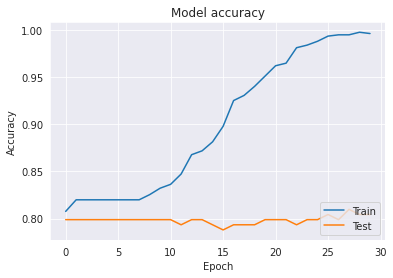

In [0]:
# Plot training & validation accuracy values

plt.plot(historyTS.history['accuracy'])
plt.plot(historyTS.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Classes'], loc='lower right')
plt.savefig('ModalSenseBinaryAccuracyTSBinary.png')
plt.show()


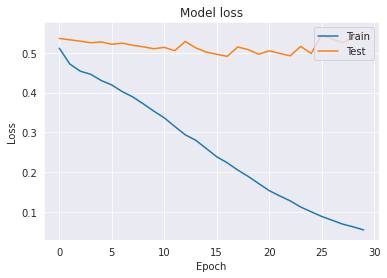

In [0]:
# Plot training & validation loss values

plt.plot(historyTS.history['loss'])
plt.plot(historyTS.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('ModalSenseBinaryLossTSBinary.png')
plt.show()

#### Matrix Sentences

In [0]:
# Train newly tuned Model

modelMS = define_model2(100, 300)
historyMS = modelMS.fit(x = [x_trainMS, x_trainMS, x_trainMS], y = y_trainMS, validation_data=([x_testMS, x_testMS, x_testMS], y_testMS), shuffle = True, epochs = 30, batch_size = 16) #16

Epoch 1/30
14/14 [==============================] - 1s 90ms/step - loss: 0.6341 - accuracy: 0.6952 - val_loss: 0.6471 - val_accuracy: 0.6792
Epoch 2/30
14/14 [==============================] - 1s 80ms/step - loss: 0.5700 - accuracy: 0.7476 - val_loss: 0.6401 - val_accuracy: 0.6792
Epoch 3/30
14/14 [==============================] - 1s 79ms/step - loss: 0.5582 - accuracy: 0.7476 - val_loss: 0.6454 - val_accuracy: 0.6792
Epoch 4/30
14/14 [==============================] - 1s 80ms/step - loss: 0.5400 - accuracy: 0.7476 - val_loss: 0.6464 - val_accuracy: 0.6792
Epoch 5/30
14/14 [==============================] - 1s 79ms/step - loss: 0.5265 - accuracy: 0.7476 - val_loss: 0.6409 - val_accuracy: 0.6792
Epoch 6/30
14/14 [==============================] - 1s 79ms/step - loss: 0.5164 - accuracy: 0.7476 - val_loss: 0.6323 - val_accuracy: 0.6792
Epoch 7/30
14/14 [==============================] - 1s 79ms/step - loss: 0.4978 - accuracy: 0.7524 - val_loss: 0.6340 - val_accuracy: 0.6792
Epoch 8/30
14

#### Narrow Classes

In [0]:
# Train newly tuned Model

model_epde = define_model2(100, 300)
history_epde = model_epde.fit(x = [x_train_epde, x_train_epde, x_train_epde], y = y_train_epde, validation_data=([x_test_epde, x_test_epde, x_test_epde], y_test_epde), shuffle = True, epochs = 40, batch_size = 16) #16

Epoch 1/40
16/16 [==============================] - 1s 91ms/step - loss: 0.6664 - accuracy: 0.6328 - val_loss: 0.7225 - val_accuracy: 0.4688
Epoch 2/40
16/16 [==============================] - 1s 84ms/step - loss: 0.6395 - accuracy: 0.6562 - val_loss: 0.7402 - val_accuracy: 0.4688
Epoch 3/40
16/16 [==============================] - 1s 83ms/step - loss: 0.6245 - accuracy: 0.6562 - val_loss: 0.7404 - val_accuracy: 0.4688
Epoch 4/40
16/16 [==============================] - 1s 83ms/step - loss: 0.6083 - accuracy: 0.6602 - val_loss: 0.7454 - val_accuracy: 0.4688
Epoch 5/40
16/16 [==============================] - 1s 82ms/step - loss: 0.5930 - accuracy: 0.6602 - val_loss: 0.7285 - val_accuracy: 0.4688
Epoch 6/40
16/16 [==============================] - 1s 83ms/step - loss: 0.5737 - accuracy: 0.6875 - val_loss: 0.7521 - val_accuracy: 0.4688
Epoch 7/40
16/16 [==============================] - 1s 82ms/step - loss: 0.5544 - accuracy: 0.6758 - val_loss: 0.7190 - val_accuracy: 0.4688
Epoch 8/40
16